**DSCI 100 Final Project**

This report analyzes data from the Minecraft Server created by a UBC research group led by Frank Wood. In doing so, this project sets out to find **which variables in the *players.csv* data set are the best predictors of newsletter subscription**. This will be an important first step towards answering the broad question of interest:

**What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**


The *players.csv* dataset consists of the following variables:

**experience:**
This variable measures each player's experience classification.

**subscription:**
This variable measures each player's subscription status.

**hashedEmail:**
This variable appears to be an encrypted version of each player's email address.

**played_hours:**
This variable measures the total hours played by each player.

**name:**
This variable contains each player's name.

**gender:**
This variable contains information on each player's gender identification.

**Age:**
This variable contains information on each player's age.

**General Methodology:**
In this report, we will conduct and optimize K-NN classification algorithm for every variable that we consider to be a relevant predictor of subscription status, that is, we are excluding the *hashedEmail* and *name* columns from our analysis. Then we will compare various methods of testing these models that we have learned throughout the course such as Accuracy, Precision, and Recall. 



In [3]:
print("Loading data")

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
players <- read_csv("Data/players.csv")
sessions <- read_csv("Data/sessions.csv")

[1] "Loading data"


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Methods & Results:
- describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
- loads data 
- wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 

note: all figures should have a figure number and a legend

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


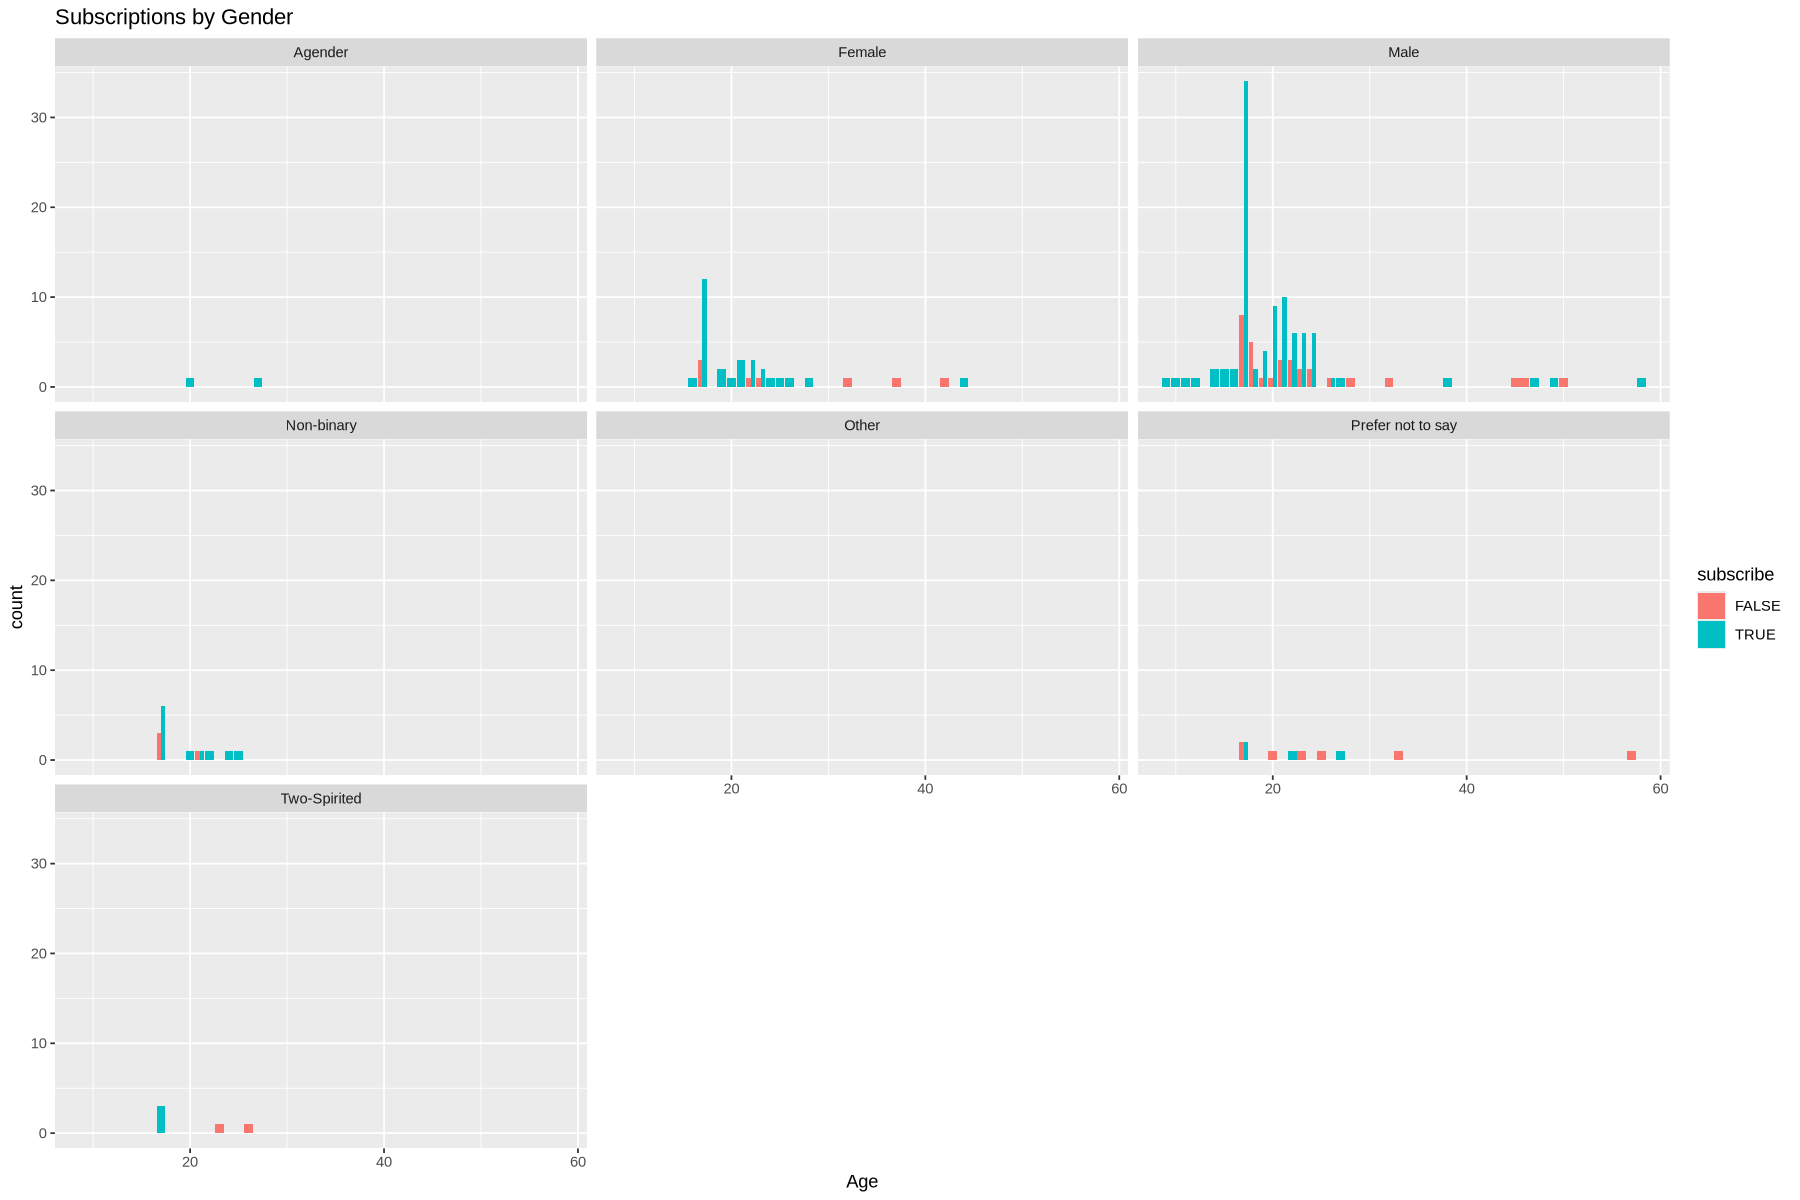

In [4]:
#indira's method section: when combined, do age and gender make a good predictor of a gamer's subscription status?

players_ic <- players |> select(subscribe, Age, gender) 
#wrangling the data so only the necessary columns for this question are left. 

options(repr.plot.width = 15, repr.plot.height = 10)
players_ic_vis <- players_ic |> ggplot(aes(Age, fill = subscribe)) + geom_bar(position = "dodge") + 
facet_wrap(facets = vars(gender)) + ggtitle("Subscriptions by Gender")
players_ic_vis
#faceting the gender column to visualize how the subscription proportions compare across genders with respect to age

Discussion:
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to

**Max:** I will be looking at how good of a predictor Age is for Subscription status.

In [5]:
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


**Step 1:**

In [6]:
players_age_sub <- players %>%
    select(Age, subscribe)
players_fct <- players_age_sub %>%
    mutate(subscribe = as_factor(subscribe))
player_clean <- players_fct %>%
    filter(Age != "NA")
player_clean

Age,subscribe
<dbl>,<fct>
9,TRUE
17,TRUE
17,FALSE
⋮,⋮
22,FALSE
57,FALSE
17,FALSE


In this step I selected my two variables of interest, *Age* and *subscribe*. I then converted the subscribe variable into a factor so that it would work within a K-NN classfication algorithhm. Finally, I cleaned out the NA values from the age column, now this data is cleaned and ready to be put into a classification model. 

**Step 2: K-NN Model Workflow**

**Martin:** I will be looking at whether experience level is a good predictors of subscription status.